<a href="https://colab.research.google.com/github/BeataStultica/neural_network/blob/main/laba5_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import argparse 
from imutils import paths
import time 
import cv2 
import random
import os
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers import BatchNormalization
import zipfile
import zipfile
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
zip_file = '/content/gdrive/MyDrive/cats.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

In [3]:
fpath = "/content/cats/"
random_seed = 42

categories = os.listdir(fpath)
print("List of categories = ",categories,"\n\nCategories = ", len(categories))

List of categories =  ['caracal', 'sphinx', 'british', 'norwegian_forest'] 

Categories =  4


In [4]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img_array = Image.fromarray(img, 'RGB')
            
            resized_img = img_array.resize((227, 227))
            
            img_lst.append(np.array(resized_img))
            
            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))

No. of images loaded =  4043 
No. of labels loaded =  4043


In [13]:
"""from keras.applications.inception_v3 import InceptionV3
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization

base_model = InceptionV3(input_shape = (227, 227, 3),weights='imagenet', include_top=False)

transfer_learning_arch = base_model.output
transfer_learning_arch = GlobalAveragePooling2D()(transfer_learning_arch)
transfer_learning_arch = Dense(1024, activation='relu')(transfer_learning_arch)
transfer_learning_arch = Dropout(0.4)(transfer_learning_arch)
transfer_learning_arch = Dense(512, activation='relu')(transfer_learning_arch)
transfer_learning_arch = Dropout(0.4)(transfer_learning_arch)
predictions = Dense(4, activation='softmax')(transfer_learning_arch)

transfer_learning_model = Model(inputs=base_model.input, outputs=predictions)
transfer_learning_model.summary()

#opt = Adadelta(lr=0.3, rho=0.95, epsilon=1e-08, decay=1e-2 / 100)
transfer_learning_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])"""
from keras.models import Model
from keras.layers.merge import concatenate
from keras.layers import Conv2D , MaxPool2D , Input , GlobalAveragePooling2D ,AveragePooling2D, Dense , Dropout ,Activation, Flatten , BatchNormalization


def conv_with_Batch_Normalisation(prev_layer , nbr_kernels , filter_Size , strides =(1,1) , padding = 'same'):
    x = Conv2D(filters=nbr_kernels, kernel_size = filter_Size, strides=strides , padding=padding)(prev_layer)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation='relu')(x)
    return x

def StemBlock(prev_layer):
    x = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 32, filter_Size=(3,3) , strides=(2,2))
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 32, filter_Size=(3,3))
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 64, filter_Size=(3,3))
    x = MaxPool2D(pool_size=(3,3) , strides=(2,2)) (x)
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 80, filter_Size=(1,1))
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 192, filter_Size=(3,3))
    x = MaxPool2D(pool_size=(3,3) , strides=(2,2)) (x)
    
    return x    
    

def InceptionBlock_A(prev_layer  , nbr_kernels):
    
    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 64, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels=96, filter_Size=(3,3))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels=96, filter_Size=(3,3))
    
    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels=48, filter_Size=(1,1))
    branch2 = conv_with_Batch_Normalisation(branch2, nbr_kernels=64, filter_Size=(3,3)) # may be 3*3
    
    branch3 = AveragePooling2D(pool_size=(3,3) , strides=(1,1) , padding='same') (prev_layer)
    branch3 = conv_with_Batch_Normalisation(branch3, nbr_kernels = nbr_kernels, filter_Size = (1,1))
    
    branch4 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels=64, filter_Size=(1,1))
    
    output = concatenate([branch1 , branch2 , branch3 , branch4], axis=3)
    
    return output



def InceptionBlock_B(prev_layer , nbr_kernels):
    
    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = nbr_kernels, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = nbr_kernels, filter_Size = (7,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = nbr_kernels, filter_Size = (1,7))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = nbr_kernels, filter_Size = (7,1))    
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 192, filter_Size = (1,7))
    
    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = nbr_kernels, filter_Size = (1,1))
    branch2 = conv_with_Batch_Normalisation(branch2, nbr_kernels = nbr_kernels, filter_Size = (1,7))
    branch2 = conv_with_Batch_Normalisation(branch2, nbr_kernels = 192, filter_Size = (7,1))
    
    branch3 = AveragePooling2D(pool_size=(3,3) , strides=(1,1) , padding ='same') (prev_layer)
    branch3 = conv_with_Batch_Normalisation(branch3, nbr_kernels = 192, filter_Size = (1,1))
    
    branch4 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 192, filter_Size = (1,1))
    
    output = concatenate([branch1 , branch2 , branch3 , branch4], axis = 3)
    
    return output    


    
def InceptionBlock_C(prev_layer):
    
    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 448, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 384, filter_Size = (3,3))
    branch1_1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 384, filter_Size = (1,3))    
    branch1_2 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 384, filter_Size = (3,1))
    branch1 = concatenate([branch1_1 , branch1_2], axis = 3)
    
    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 384, filter_Size = (1,1))
    branch2_1 = conv_with_Batch_Normalisation(branch2, nbr_kernels = 384, filter_Size = (1,3))
    branch2_2 = conv_with_Batch_Normalisation(branch2, nbr_kernels = 384, filter_Size = (3,1))
    branch2 = concatenate([branch2_1 , branch2_2], axis = 3)
    
    branch3 = AveragePooling2D(pool_size=(3,3) , strides=(1,1) , padding='same')(prev_layer)
    branch3 = conv_with_Batch_Normalisation(branch3, nbr_kernels = 192, filter_Size = (1,1))
    
    branch4 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 320, filter_Size = (1,1))
    
    output = concatenate([branch1 , branch2 , branch3 , branch4], axis = 3)
    
    return output

def ReductionBlock_A(prev_layer):
    
    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 64, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 96, filter_Size = (3,3))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 96, filter_Size = (3,3) , strides=(2,2) ) #, padding='valid'
    
    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 384, filter_Size=(3,3) , strides=(2,2) )
    
    branch3 = MaxPool2D(pool_size=(3,3) , strides=(2,2) , padding='same')(prev_layer)
    
    output = concatenate([branch1 , branch2 , branch3], axis = 3)
    
    return output

    

def ReductionBlock_B(prev_layer):
    
    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 192, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 192, filter_Size = (1,7))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 192, filter_Size = (7,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 192, filter_Size = (3,3) , strides=(2,2) , padding = 'valid')
    
    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 192, filter_Size = (1,1) )
    branch2 = conv_with_Batch_Normalisation(branch2, nbr_kernels = 320, filter_Size = (3,3) , strides=(2,2) , padding='valid' )

    branch3 = MaxPool2D(pool_size=(3,3) , strides=(2,2) )(prev_layer)
    
    output = concatenate([branch1 , branch2 , branch3], axis = 3)
    
    return output

def auxiliary_classifier(prev_Layer):
    x = AveragePooling2D(pool_size=(5,5) , strides=(3,3)) (prev_Layer)
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 128, filter_Size = (1,1))
    x = Flatten()(x)
    x = Dense(units = 768, activation='relu') (x)
    x = Dropout(rate = 0.2) (x)
    x = Dense(units = 1000, activation='softmax') (x)
    return x



def InceptionV3():
    
    input_layer = Input(shape=(227 , 227 , 3))
    
    x = StemBlock(input_layer)
    
    x = InceptionBlock_A(prev_layer = x ,nbr_kernels = 32)
    x = InceptionBlock_A(prev_layer = x ,nbr_kernels = 64)
    x = InceptionBlock_A(prev_layer = x ,nbr_kernels = 64)
    
    x = ReductionBlock_A(prev_layer = x )
    
    x = InceptionBlock_B(prev_layer = x  , nbr_kernels = 128)
    x = InceptionBlock_B(prev_layer = x , nbr_kernels = 160)
    x = InceptionBlock_B(prev_layer = x , nbr_kernels = 160)
    x = InceptionBlock_B(prev_layer = x , nbr_kernels = 192)
    
    Aux = auxiliary_classifier(prev_Layer = x)
    
    x = ReductionBlock_B(prev_layer = x)
    
    x = InceptionBlock_C(prev_layer = x)
    x = InceptionBlock_C(prev_layer = x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(units=2048, activation='relu') (x)
    x = Dropout(rate = 0.2) (x)
    x = Dense(units=4, activation='softmax') (x)
    
    model = Model(inputs = input_layer , outputs = [x , Aux] , name = 'Inception-V3')
    
    return model

In [16]:
model = InceptionV3()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "Inception-V3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_192 (Conv2D)            (None, 114, 114, 32  896         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_191 (Batch  (None, 114, 114, 32  128        ['conv2d_192[0][0]']             
 Normalization)                 )                                                      

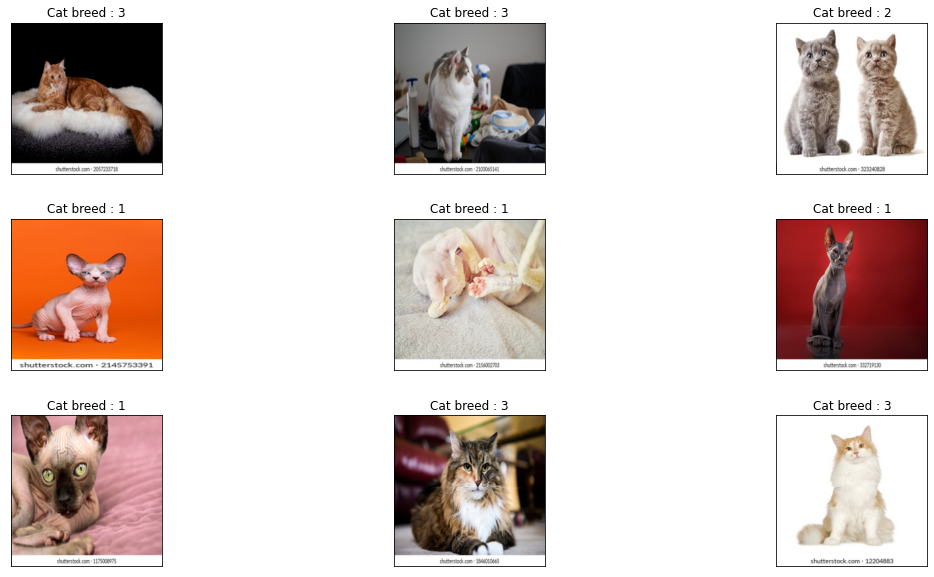

In [17]:
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Cat breed : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()

images = np.array(images)
labels = np.array(labels)
display_rand_images(images, labels)

In [18]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (3234, 227, 227, 3)
y_train shape =  (3234,)

x_test shape =  (809, 227, 227, 3)
y_test shape =  (809,)


In [19]:
model.fit(x_train, y_train, epochs=40, batch_size = 64, validation_data=(x_test, y_test), 
          steps_per_epoch=len(x_train)//64, validation_steps=len(x_test)//64)

Epoch 1/40
50/50 [==============================] - 58s 660ms/step - loss: 3.2836 - dense_11_loss: 1.6478 - dense_9_loss: 1.6357 - dense_11_accuracy: 0.3781 - dense_9_accuracy: 0.3944 - val_loss: 5.6778 - val_dense_11_loss: 1.6680 - val_dense_9_loss: 4.0098 - val_dense_11_accuracy: 0.2617 - val_dense_9_accuracy: 0.2617
Epoch 2/40
50/50 [==============================] - 34s 617ms/step - loss: 2.3266 - dense_11_loss: 1.1572 - dense_9_loss: 1.1695 - dense_11_accuracy: 0.5009 - dense_9_accuracy: 0.5167 - val_loss: 3.9015 - val_dense_11_loss: 2.0018 - val_dense_9_loss: 1.8997 - val_dense_11_accuracy: 0.2396 - val_dense_9_accuracy: 0.2396
Epoch 3/40
50/50 [==============================] - 31s 619ms/step - loss: 2.0624 - dense_11_loss: 1.0406 - dense_9_loss: 1.0218 - dense_11_accuracy: 0.5713 - dense_9_accuracy: 0.5814 - val_loss: 4.0009 - val_dense_11_loss: 2.0397 - val_dense_9_loss: 1.9612 - val_dense_11_accuracy: 0.2617 - val_dense_9_accuracy: 0.2396
Epoch 4/40
50/50 [===================

In [21]:
model.evaluate(x_test, y_test)

26/26 [==============================] - 2s 90ms/step - loss: 1.5271 - dense_11_loss: 0.7428 - dense_9_loss: 0.7843 - dense_11_accuracy: 0.8121 - dense_9_accuracy: 0.8121


[1.5271258354187012,
 0.7427841424942017,
 0.7843417525291443,
 0.8121137022972107,
 0.8121137022972107]

In [22]:
model.save('laba5_inceptionv3_cats.h5')